# Création d'une segmentation client pour Olist

-------------------------------------------------------------------------------------------------------------------------------

Problématique : identifier différents comportements des clients afin de pouvoir faire du ciblage marketing et augmenter ainsi la rentabilité de l'entreprise

Nous disposons de plusieurs informations anonymisées de la société Olist sur : 
- les commandes
- les clients
- les produits
- les catégories des produits
- des informations sur le paiment des commandes
- les vendeurs.

Il est important de noter qu'une commande peut contenir des produits de différents vendeurs.


In [1]:
#notre package de fonctionnalités
from Package import Scripts_Analyse01 as pk

import pandas as pd
import numpy as np
import missingno
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.stats
from scipy.stats import pearsonr
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from yellowbrick.features import ParallelCoordinates
from plotly.graph_objects import Layout
import jenkspy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.features import PCA as PCA_yellow
from yellowbrick.style import set_palette
# Import train_test_split function
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
#Import knearest neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import SelectKBest, f_classif,mutual_info_classif
from skfeature.function.similarity_based import fisher_score
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK, Trials
 
import mlflow
from datetime import datetime

Regardons les différentes tables à notre disposition et s'il y a des doublons où des valeurs manquantes

Commençons par la table des commandes.

In [2]:
orders = pd.read_csv('./input/olist_orders_dataset.csv')

In [3]:
orders.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [4]:
orders.shape

(99441, 8)

Nous avons 99 441 lignes et 8 variables.

In [5]:
orders[['order_id']].duplicated().sum()

0

Nous avons une ligne par commande et il n'y a pas de doublons dans cette table.

Regardons si cette table contient des données manquantes.

In [6]:
tab=pk.del_Nan(orders, 0.0000000001,0, 0)

In [7]:
tab

,index,freq
4,order_approved_at,0.001609
5,order_delivered_carrier_date,0.017930
6,order_delivered_customer_date,0.029817


Cette table contient très peu de données manquantes.

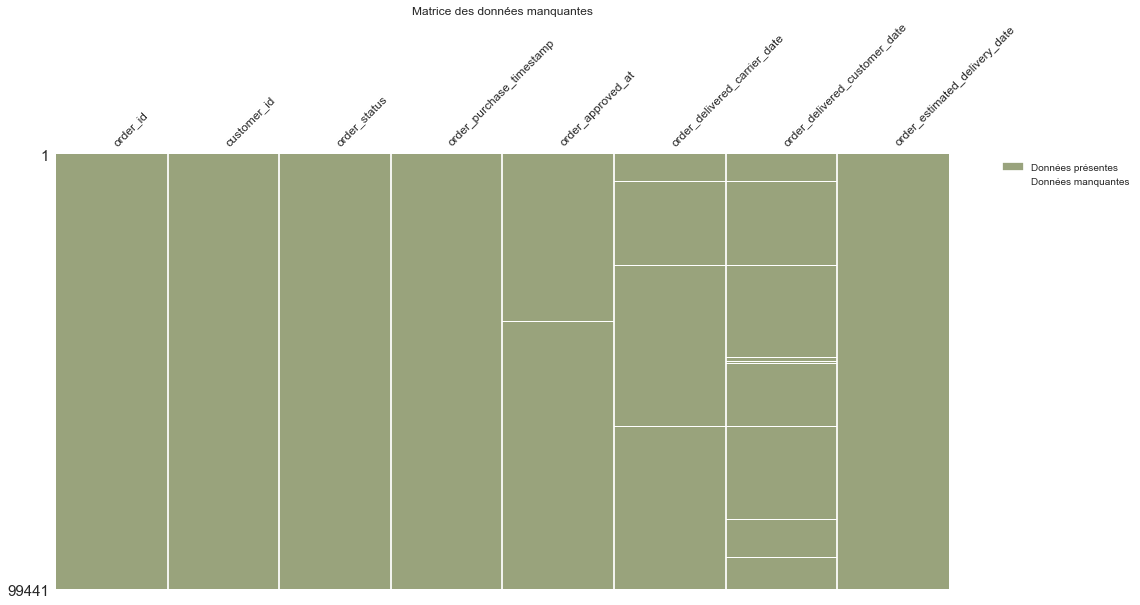

In [8]:
pk.matrix_vm(orders, (16,8), (0.60, 0.64, 0.49))

Nous observons des données manquantes pour les dates de livraison par exemple. Nous pouvons conserver ces données car ce sont surement des commandes non livrées.

In [9]:
orders.loc[pd.isna(orders["order_approved_at"])==True]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaN,NaN,NaN,2018-09-12 00:00:00
1801,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaN,NaN,NaN,2018-10-17 00:00:00
1868,df8282afe61008dc26c6c31011474d02,aa797b187b5466bc6925aaaa4bb3bed1,canceled,2017-03-04 12:14:30,NaN,NaN,NaN,2017-04-10 00:00:00
2029,8d4c637f1accf7a88a4555f02741e606,b1dd715db389a2077f43174e7a675d07,canceled,2018-08-29 16:27:49,NaN,NaN,NaN,2018-09-13 00:00:00
2161,7a9d4c7f9b068337875b95465330f2fc,7f71ae48074c0cfec9195f88fcbfac55,canceled,2017-05-01 16:12:39,NaN,NaN,NaN,2017-05-30 00:00:00
...,...,...,...,...,...,...,...,...
97696,5a00b4d35edffc56b825c3646a99ba9d,6a3bdf004ca96338fb5fad1b8d93c2e6,canceled,2017-07-02 15:38:46,NaN,NaN,NaN,2017-07-25 00:00:00
98415,227c804e2a44760671a6a5697ea549e4,62e7477e75e542243ee62a0ba73f410f,canceled,2017-09-28 15:02:56,NaN,NaN,NaN,2017-10-16 00:00:00
98909,e49e7ce1471b4693482d40c2bd3ad196,e4e7ab3f449aeb401f0216f86c2104db,canceled,2018-08-07 11:16:28,NaN,NaN,NaN,2018-08-10 00:00:00
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaN,NaN,NaN,2018-10-01 00:00:00


Nous avons des données manquantes pour les commandes annulées, ce qui est normal car nous n'avons pas les informations.
Est ce qu'il est intéressant de conserver ces données ??????

Il serait interessant de créer des variables comme le délai de livraison au client, délai de livraison au transporteur et le délai entre la livraison transporteur et la livraison client.

Nous créerons une fonction pour la création des variables et l'aggrégation ensuite. Passons à l'étude de la table reviews.

In [11]:
reviews = pd.read_csv('./input/olist_order_reviews_dataset.csv')

In [12]:
reviews.head(5)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [13]:
reviews.shape

(99224, 7)

In [14]:
reviews[['review_id', 'order_id']].duplicated().sum()

0

In [15]:
tab=pk.del_Nan(reviews, 0.0000000001,0, 0)

In [16]:
tab

,index,freq
3,review_comment_title,0.883415
4,review_comment_message,0.587025


Il n'y a pas de doublons dans cette table. Les colonnes review_comment_title et review_comment_message	contiennent des données vides, mais le client n'est pas obligé de remplir ces données. Nous créerons des colonnes binaires sur ces colonnes et nous ferons des aggrégations par commande par la suite.
Etudions la table concernant les paiements.

In [19]:
payments = pd.read_csv('./input/olist_order_payments_dataset.csv')

In [20]:
payments.head(5)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [21]:
payments[['order_id', 'payment_sequential']].duplicated().sum()

0

In [22]:
tab=pk.del_Nan(payments, 0.0000000001,0, 0)
tab

,index,freq


Il n'y a pas de doublons et il n'y a pas de données manquantes dans cette table. Nous allons calculer les sommes par commandes et les moyennes. Nous créerons une fonction pour faire ce traitement. Analysons la table des produits, des catégories de produits et des vendeurs.

In [23]:
prod_transl = pd.read_csv('./input/product_category_name_translation.csv')

In [24]:
products = pd.read_csv('./input/olist_products_dataset.csv')

In [25]:
sellers = pd.read_csv('./input/olist_sellers_dataset.csv')

In [26]:
prod_transl.head(5)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [27]:
prod_transl[['product_category_name']].duplicated().sum()

0

In [28]:
tab=pk.del_Nan(prod_transl, 0.0000000001,0, 0)
tab

,index,freq


In [29]:
products.head(5)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [30]:
products[['product_id']].duplicated().sum()

0

In [31]:
tab=pk.del_Nan(products, 0.0000000001,0, 0)
tab

,index,freq
1,product_category_name,0.018512
2,product_name_lenght,0.018512
3,product_description_lenght,0.018512
4,product_photos_qty,0.018512
5,product_weight_g,0.000061
6,product_length_cm,0.000061
7,product_height_cm,0.000061
8,product_width_cm,0.000061


Nous pouvons remplacer les vides par 0 pour la table produit, car cela nous indiquera qu'il n'y a pas d'information pour ces produits.

In [32]:
sellers.head(5)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [33]:
sellers[['seller_id']].duplicated().sum()

0

In [34]:
tab=pk.del_Nan(sellers, 0.0000000001,0, 0)
tab

,index,freq


Il n'y a pas de doublons dans ces tables. Il existe des données manquantes dans la tables produits, mais très peu. Nous conservons les données telles quelles. Regardons la table contenant les produits par commande.

In [35]:
items = pd.read_csv('./input/olist_order_items_dataset.csv')

In [36]:
items.head(5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [37]:
items[['order_id','product_id', 'order_item_id']].duplicated().sum()

0

In [38]:
tab=pk.del_Nan(items, 0.0000000001,0, 0)
tab

,index,freq


Il n'y a aucun doublons et aucunes données manquantes.

Regardons la table clients

In [40]:
customer_obj = pd.read_csv('./input/olist_customers_dataset.csv')

In [41]:
customer_obj

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


Nous observons qu'un customer_unique_id peut avoir plusieurs customer_id. Un client peut donc avoir plusieurs comptes client. Il faudra réaliser une aggrégation grâce à l'id unique du client.

In [42]:
customer_obj[['customer_id','customer_unique_id']].duplicated().sum()

0

In [43]:
tab=pk.del_Nan(customer_obj, 0.0000000001,0, 0)
tab

,index,freq


Il n'y a pas de doublons et il n'y a pas de données manquantes dans cette table.

Regardons la table de geolocalisation.

In [44]:
geoloc = pd.read_csv('./input/olist_geolocation_dataset.csv')   

In [45]:
geoloc.head(5)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [46]:
geoloc[['geolocation_zip_code_prefix','geolocation_city','geolocation_state']].duplicated().sum()

972251

In [47]:
geoloc.shape

(1000163, 5)

Nous avons beaucoup de doublons dans cette table. Nous n'allons pas l'utiliser.
Nous pourrions par la suite rechercher une table des localisations des villes du Brésil sur internet afin d'ajouter une localisation des clients par ville.

Nous pouvons à présent fusionner nos tables et faire des aggrégations par client unique.

In [48]:

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
#####encoder les colonnes catégorielles
def one_hot_encoder(df, exclude=[], nan_as_category = True):
    cols=filter(lambda x: ("_id" not in (x)) and x not in (exclude), df.columns)
    original_columns = list(cols)
    categorical_columns = [col for col in original_columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

def agg_by_group(df_test2, tab, cols, agg_name, col_index, col_by_cat):
    for col in cols:
        df_calcul=df_test2.pivot_table(values=col, index=col_index, columns=col_by_cat, aggfunc=agg_name).reset_index()
        lt_col=list(filter(lambda x: x not in (col_index), df_calcul.columns))
        lt_col=[e + "_"+str(col) for e in lt_col]
        lt_col.insert(0,col_index)
        df_calcul.columns=pd.Index([e for e in lt_col])
        df_calcul=df_calcul.fillna(0)
        tab=tab.merge(df_calcul, how='left', on=col_index)
        #display(tab)
    return tab

def difference_dates(date2, date1, new_column, df, var_i=0):    
    df2=df.copy()
    if var_i==0:
        df2[new_column] = (pd.to_datetime(df2[date2]) - pd.to_datetime(df2[date1])).dt.days
    if var_i==1:
        df2[new_column] = (pd.to_datetime(date2) - pd.to_datetime(df2[date1])).dt.days
    return df2

# Preprocess application_train.csv and application_test.csv
def orders(num_rows = None, nan_as_category = False):
    # Read data and merge
    ####lecture des fichiers application_train et application test
    df = pd.read_csv('./input/olist_orders_dataset.csv', nrows= num_rows)
    print("df shape: {}".format(len(df)))
    
    #calcul aggregation - add column
    df=difference_dates("order_delivered_customer_date", "order_approved_at", 'time_delivered_approved_customer', df)
    df=difference_dates("order_approved_at", "order_purchase_timestamp", 'time_approval_purchase', df)
    df=difference_dates("order_delivered_carrier_date", "order_approved_at", 'time_delivery_carrier_approved', df)
    df=difference_dates("order_delivered_customer_date", "order_delivered_carrier_date", 'time_delivery_customer_carrier', df)
    df=difference_dates("order_delivered_customer_date", "order_estimated_delivery_date", 'time_delivery_customer_estimated', df)
        
    df["order_purchase_year_month"]=pd.to_datetime(df["order_purchase_timestamp"]).dt.strftime('%Y%m')
    df["order_purchase_timestamp"]=pd.to_datetime(df["order_purchase_timestamp"])
    df=df.drop(['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'], axis=1)
    data, data_cat = one_hot_encoder(df, ['order_purchase_timestamp', "order_id"])
    del df
    gc.collect()
    return data, data_cat


# Preprocess bureau.csv and bureau_balance.csv
def order_reviews(num_rows = None, nan_as_category = True):
    date1 = datetime.now()
    ####lecture des data et encodage des variable cat
    reviews = pd.read_csv('./input/olist_order_reviews_dataset.csv', nrows = num_rows)
    #bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    print("reviews shape: {}".format(len(reviews)))
    ####calcul d'agregat pour les variables

    reviews['review_comment_message_ind']=[0 if pd.isna(i.review_comment_message)==True else 1 for i in reviews.itertuples()]
    reviews['review_comment_title_ind']=[0 if pd.isna(i.review_comment_title)==True else 1 for i in reviews.itertuples()]
    reviews['review_created_days'] = [None if pd.isna(i.review_creation_date)==True else (pd.to_datetime(i.review_creation_date) - date1).days for i in reviews.itertuples()]
    reviews['review_answer_days'] = [None if pd.isna(i.review_answer_timestamp)==True else (pd.to_datetime(i.review_answer_timestamp) - date1).days for i in reviews.itertuples()]
    reviews_aggregations = {
                            'review_score': ['mean'],
                            'review_comment_message_ind': ['sum'],
                            'review_comment_title_ind': ['sum'],
                            'review_created_days': ['sum'],
                            'review_answer_days': ['sum']
                           }
    
    del reviews["review_comment_message"]
    del reviews["review_comment_title"]
    del reviews["review_creation_date"]
    del reviews["review_answer_timestamp"]
    reviews_agg = reviews.groupby('order_id').agg(reviews_aggregations)
    reviews_agg.columns = pd.Index([e[0] + "_" + e[1].lower() for e in reviews_agg.columns.tolist()])
    del reviews
    print("reviews agg shape: {}".format(len(reviews_agg)))
    gc.collect()
    return reviews_agg

# Preprocess previous_applications.csv
def order_payments(num_rows = None, nan_as_category = True):
    payments = pd.read_csv('./input/olist_order_payments_dataset.csv', nrows = num_rows)
    #Encode categoricals variables
    data, data_cat = one_hot_encoder(payments)
    #create aggregation on quantitatives variables
    paid_aggregations = {'payment_value': ['sum'],
                  'payment_installments': ['sum']}
    for col in data_cat:
        if col!="order_id":
            paid_aggregations[col] = ['sum']
    paid_agg = data.groupby("order_id").agg(paid_aggregations)
    #rename columns
    paid_agg.columns = pd.Index([e[0] + "_" + e[1].lower() for e in paid_agg.columns.tolist()])
    
    #aggregation quantitatives var by group
    payment_aggregations=agg_by_group(payments, paid_agg, ["payment_value"], "sum","order_id","payment_type" )
    del payments,data_cat
    gc.collect()
    return payment_aggregations

def product_category_translation(num_rows = None, nan_as_category = True):
    prod_transl = pd.read_csv('./input/product_category_name_translation.csv', nrows = num_rows)
    #ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    
    gc.collect()
    return prod_transl
    
# Preprocess installments_payments.csv
def products(num_rows = None, nan_as_category = True):
    products = pd.read_csv('./input/olist_products_dataset.csv', nrows = num_rows)
    cat = product_category_translation(num_rows,nan_as_category)
    #ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    products=products.merge(cat, how="left", on="product_category_name")
    del products["product_category_name"]
    data, data_cat = one_hot_encoder(products)
    data=data.fillna(0)
    del cat
    gc.collect()
    return data, data_cat

# Preprocess credit_card_balance.csv
def sellers(num_rows = None, nan_as_category = True):
    sellers = pd.read_csv('./input/olist_sellers_dataset.csv', nrows = num_rows)
    #cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    
    #del cc
    gc.collect()
    return sellers


# Preprocess POS_CASH_balance.csv
def order_items(num_rows = None, nan_as_category = True):
    items = pd.read_csv('./input/olist_order_items_dataset.csv', nrows = num_rows)
    products_obj, prods_cat=products(num_rows = None, nan_as_category = True)
    #pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    items=items.merge(products_obj, how="left", on="product_id")
    #sell=sellers(num_rows = None, nan_as_category = True)
    #items=items.merge(sell, how="left", on="seller_id")
    items_aggregations = {}
    df_num=items.select_dtypes(include=[np.float])
    for col in prods_cat:
        if ("_id" not in col) and ("_date" not in col):
              items_aggregations[col] = ['sum']
        elif col in ["product_id", "seller_id", "item_id"]:
              items_aggregations[col] = ['size']
        elif "_date" in col:
              items_aggregations[col] = ['max']
    
    for col_num in df_num:
        items_aggregations[col_num] = ['mean']
    items_agg = items.groupby("order_id").agg(items_aggregations)
    items_agg.columns = pd.Index([e[0] + "_" + e[1] for e in items_agg.columns.tolist()])
    del items, products_obj
    gc.collect()
    
    return items_agg


def orders_informations(num_rows = None, nan_as_category = True):
    with timer("Orders "):
        df, data_cat = orders(num_rows)
        print("Order df shape:", df.shape)
        gc.collect()
    with timer("Orders reviews"):
        reviews = order_reviews(num_rows)
        print("Reviews df shape:", reviews.shape)
        df = df.merge(reviews, how='left', on='order_id')
        del reviews
        gc.collect()
    with timer("Process order payments"):
        payments = order_payments(num_rows)
        print("Order payments df shape:", payments.shape)
        df = df.merge(payments, how='left', on='order_id')
        del payments
        gc.collect()
    
    with timer("Process order items"):
        items = order_items(num_rows)
        print("Order items df shape:", items.shape)
        df = df.merge(items, how='left', on='order_id')
        del items
        gc.collect()  
    return df


# Preprocess credit_card_balance.csv
def customer(num_rows = None, nan_as_category = True):
    customer_obj = pd.read_csv('./input/olist_customers_dataset.csv', nrows = num_rows)
    #del cc
    gc.collect()
    return customer_obj

# Il y a des doublons dans cette table > une ville ou un code zip a différentes coordonnées
def geolocation(num_rows = None, nan_as_category = True):
    geoloc = pd.read_csv('./input/olist_geolocation_dataset.csv', nrows = num_rows)    
    #del cc
    gc.collect()
    return geoloc

In [49]:
# lance chaque fonction avec un timer
def main(debug = True):
    num_rows = 1000 if debug else None
    
    ####import fichiers + calcul agregats (new features) et jointure de toutes les tables
    ### + nettoyage memoire
    with timer("Orders informations"):
        df = orders_informations(num_rows)
        print("orders informations shape:", df.shape)
        gc.collect()
    
    with timer("Process customer"):
        customer_obj = customer(num_rows)
        customer_obj = customer_obj.merge(df, how='left', on='customer_id')
        print("Customer df shape:", customer_obj.shape)
        del df
        gc.collect()
        customer_obj.columns = customer_obj.columns.str.strip()    
        customer_obj.columns = customer_obj.columns.str.replace(' ', '_')
        customer_obj.columns = customer_obj.columns.str.replace(r"[^a-zA-Z\d\_]+", "")  
        customer_obj.columns = customer_obj.columns.str.replace(r"[^a-zA-Z\d\_]+", "")
        
        
        ##############a modifier
        ##Moyenne - median by customer
        #count nb commande + nb produit mean + nb prod by category en moy par commande + time moyen
        customer_aggregations={}
        cols=list(customer_obj.columns)
        cols_float=customer_obj.select_dtypes(include=[np.float])
        col_ok=[]       
        
        
        for col in cols:
            if (("_sum" in col) and ("payment_" not in col)) or ('order_status' in col) or ('order_purchase' in col) :
                customer_aggregations[col] = ['sum']
                col_ok.append(col)
            if ("payment_" in col) or "_size" in col:
                customer_aggregations[col] = ['sum', 'mean']
                col_ok.append(col)
            if "order_id" in col or "customer_id" in col:
                customer_aggregations[col] = ["size"]
                col_ok.append(col)
            if "time_" in col:
                customer_aggregations[col] = ['mean']
                col_ok.append(col)
            if 'order_purchase_timestamp' in col:
                customer_aggregations[col] = ['max']
                col_ok.append(col)
        for col in cols_float:
            if col not in col_ok :
                customer_aggregations[col] = ['mean', 'size']
        customer_agg = customer_obj.groupby(["customer_unique_id"]).agg(customer_aggregations)
        customer_agg.columns = pd.Index([e[0] + "_" + e[1].lower() for e in customer_agg.columns.tolist()])
        
        date_max_purchase=customer_agg['order_purchase_timestamp_max'].max()
        customer_agg=difference_dates(date_max_purchase, "order_purchase_timestamp_max", "order_purchase_timestamp_recency", customer_agg,1)
        
        del customer_obj
        gc.collect()
        return customer_agg.reset_index()
    
if __name__ == "__main__":
    #submission_file_name = "submission_kernel02.csv"
    with timer("Full complete run"):
        df = main(False)
        #, feat_importance
       

df shape: 99441
Order df shape: (99441, 43)
Orders  - done in 2s
reviews shape: 99224
reviews agg shape: 98673
Reviews df shape: (98673, 5)
Orders reviews - done in 18s
Order payments df shape: (99440, 14)
Process order payments - done in 1s
Order items df shape: (98666, 82)
Process order items - done in 1s
orders informations shape: (99441, 143)
Orders informations - done in 21s
Customer df shape: (99441, 147)
Process customer - done in 3s
Full complete run - done in 24s


In [50]:
df

,customer_unique_id,customer_id_size,order_id_size,order_purchase_timestamp_max,time_delivered_approved_customer_mean,time_approval_purchase_mean,time_delivery_carrier_approved_mean,time_delivery_customer_carrier_mean,time_delivery_customer_estimated_mean,order_status_approved_sum,...,product_photos_qty_mean_size,product_weight_g_mean_mean,product_weight_g_mean_size,product_length_cm_mean_mean,product_length_cm_mean_size,product_height_cm_mean_mean,product_height_cm_mean_size,product_width_cm_mean_mean,product_width_cm_mean_size,order_purchase_timestamp_recency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1,2018-05-10 10:56:27,6.0,0.0,1.0,4.0,-5.0,0,...,1,1500.0,1,34.0,1,7.0,1,32.0,1,160
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1,2018-05-07 11:11:27,2.0,0.0,1.0,1.0,-5.0,0,...,1,375.0,1,26.0,1,11.0,1,18.0,1,163
2,0000f46a3911fa3c0805444483337064,1,1,2017-03-10 21:05:03,25.0,0.0,2.0,23.0,-2.0,0,...,1,1500.0,1,25.0,1,50.0,1,35.0,1,585
3,0000f6ccb0745a6a4b88665a16c9f078,1,1,2017-10-12 20:29:41,20.0,0.0,0.0,19.0,-12.0,0,...,1,150.0,1,19.0,1,5.0,1,11.0,1,369
4,0004aac84e0df4da2b147fca70cf8255,1,1,2017-11-14 19:45:42,13.0,0.0,1.0,11.0,-8.0,0,...,1,6050.0,1,16.0,1,3.0,1,11.0,1,336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,1,1,2017-06-08 21:00:36,27.0,0.0,14.0,12.0,-27.0,0,...,1,30000.0,1,55.0,1,75.0,1,61.0,1,495
96092,fffea47cd6d3cc0a88bd621562a9d061,1,1,2017-12-10 20:07:56,30.0,0.0,10.0,19.0,-3.0,0,...,1,1720.0,1,33.0,1,36.0,1,27.0,1,310
96093,ffff371b4d645b6ecea244b27531430a,1,1,2017-02-07 15:49:16,14.0,0.0,0.0,14.0,-30.0,0,...,1,600.0,1,17.0,1,15.0,1,13.0,1,617
96094,ffff5962728ec6157033ef9805bacc48,1,1,2018-05-02 15:17:41,11.0,0.0,1.0,10.0,-14.0,0,...,1,444.0,1,20.0,1,14.0,1,16.0,1,168


In [51]:
df[['customer_unique_id']].duplicated().sum()

0

In [52]:
df.shape

(96096, 169)

Nous avons à présent une ligne par client, au total 96 096 et 169 variables.

Supprimons les colonnes avec des valeurs uniques.

In [53]:
pk.data_uniqueone_string(df)

customer_unique_id - count unique : 96096
customer_id_size - count unique : 9
order_id_size - count unique : 9
order_purchase_timestamp_max - count unique : 95834
time_delivered_approved_customer_mean - count unique : 251
time_approval_purchase_mean - count unique : 37
time_delivery_carrier_approved_mean - count unique : 128
time_delivery_customer_carrier_mean - count unique : 248
time_delivery_customer_estimated_mean - count unique : 331
order_status_approved_sum - count unique : 2
order_status_canceled_sum - count unique : 4
order_status_created_sum - count unique : 2
order_status_delivered_sum - count unique : 10
order_status_invoiced_sum - count unique : 2
order_status_processing_sum - count unique : 2
order_status_shipped_sum - count unique : 3
order_status_unavailable_sum - count unique : 3
deleted unique colonne : order_status_nan_sum
order_purchase_year_month_201609_sum - count unique : 2
order_purchase_year_month_201610_sum - count unique : 3
order_purchase_year_month_201612_s

In [54]:
df.shape

(96096, 163)

Il reste 163 variables

In [55]:
for i in df.columns:
    print(i)

customer_unique_id
customer_id_size
order_id_size
order_purchase_timestamp_max
time_delivered_approved_customer_mean
time_approval_purchase_mean
time_delivery_carrier_approved_mean
time_delivery_customer_carrier_mean
time_delivery_customer_estimated_mean
order_status_approved_sum
order_status_canceled_sum
order_status_created_sum
order_status_delivered_sum
order_status_invoiced_sum
order_status_processing_sum
order_status_shipped_sum
order_status_unavailable_sum
order_purchase_year_month_201609_sum
order_purchase_year_month_201610_sum
order_purchase_year_month_201612_sum
order_purchase_year_month_201701_sum
order_purchase_year_month_201702_sum
order_purchase_year_month_201703_sum
order_purchase_year_month_201704_sum
order_purchase_year_month_201705_sum
order_purchase_year_month_201706_sum
order_purchase_year_month_201707_sum
order_purchase_year_month_201708_sum
order_purchase_year_month_201709_sum
order_purchase_year_month_201710_sum
order_purchase_year_month_201711_sum
order_purchase_

Nous avions quelques données manquantes. Regardons les de plus près.

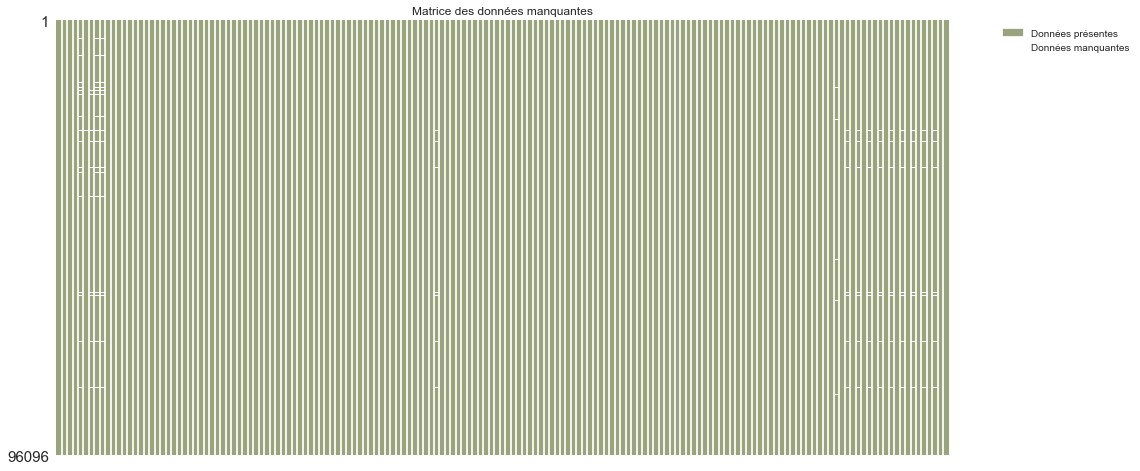

In [56]:
pk.matrix_vm(df, (16,8), (0.60, 0.64, 0.49))

In [57]:
tab=pk.del_Nan(df, 0.0000000001,0, 0)
tab

,index,freq
4,time_delivered_approved_customer_mean,0.028648
5,time_approval_purchase_mean,0.001030
6,time_delivery_carrier_approved_mean,0.017097
7,time_delivery_customer_carrier_mean,0.028524
8,time_delivery_customer_estimated_mean,0.028513
47,payment_value_sum_mean,0.000010
49,payment_installments_sum_mean,0.000010
51,payment_type_boleto_sum_mean,0.000010
53,payment_type_credit_card_sum_mean,0.000010
55,payment_type_debit_card_sum_mean,0.000010


In [58]:
df.loc[pd.isna(df["product_id_size_mean"])==True]

,customer_unique_id,customer_id_size,order_id_size,order_purchase_timestamp_max,time_delivered_approved_customer_mean,time_approval_purchase_mean,time_delivery_carrier_approved_mean,time_delivery_customer_carrier_mean,time_delivery_customer_estimated_mean,order_status_approved_sum,...,product_photos_qty_mean_size,product_weight_g_mean_mean,product_weight_g_mean_size,product_length_cm_mean_mean,product_length_cm_mean_size,product_height_cm_mean_mean,product_height_cm_mean_size,product_width_cm_mean_mean,product_width_cm_mean_size,order_purchase_timestamp_recency
123,004ad212c650c96c8a48f30855a7bcb8,1,1,2017-09-24 10:45:10,NaN,0.0,NaN,NaN,NaN,0,...,1,NaN,1,NaN,1,NaN,1,NaN,1,388
177,0071f46a072a9ae25bbe4438b15efe9c,1,1,2017-02-01 00:04:17,NaN,0.0,NaN,NaN,NaN,0,...,1,NaN,1,NaN,1,NaN,1,NaN,1,623
238,009b0127b727ab0ba422f6d9604487c7,1,1,2016-09-13 15:24:19,NaN,23.0,NaN,NaN,NaN,0,...,1,NaN,1,NaN,1,NaN,1,NaN,1,764
372,00f0b70fdcb8a6e1671b52a2472bd41f,1,1,2016-10-04 19:41:32,NaN,NaN,NaN,NaN,NaN,0,...,1,NaN,1,NaN,1,NaN,1,NaN,1,742
475,013b083525868a0437652ebf071cda03,1,1,2017-12-03 14:28:40,NaN,0.0,NaN,NaN,NaN,0,...,1,NaN,1,NaN,1,NaN,1,NaN,1,318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95593,feb643dc81ca576d83810f147e0e089c,1,1,2017-03-06 13:20:19,NaN,0.0,NaN,NaN,NaN,0,...,1,NaN,1,NaN,1,NaN,1,NaN,1,590
95612,fec36733d170d71e390acde47d74c6d6,1,1,2017-05-02 07:34:35,NaN,NaN,NaN,NaN,NaN,0,...,1,NaN,1,NaN,1,NaN,1,NaN,1,533
95754,ff222edf83338ca6b35f8e29871fa07a,1,1,2017-08-17 08:58:59,NaN,1.0,NaN,NaN,NaN,0,...,1,NaN,1,NaN,1,NaN,1,NaN,1,426
95765,ff28720521c749234b1ba19c9c986f4c,1,1,2017-02-15 11:25:14,NaN,0.0,NaN,NaN,NaN,0,...,1,NaN,1,NaN,1,NaN,1,NaN,1,609


In [59]:
for i in df.columns:
    if "product_" in i:
        df[i]=df[i].fillna(0)

Regardons les autres colonnes, il y a des valeurs manquantes car la commande n'a pas été approuvée. Remplaçons toutes les valeurs par 0 pour les variables : payment price, freight.

In [60]:
tab=pk.del_Nan(df, 0.0000000001,0, 0)
tab

,index,freq
4,time_delivered_approved_customer_mean,0.028648
5,time_approval_purchase_mean,0.001030
6,time_delivery_carrier_approved_mean,0.017097
7,time_delivery_customer_carrier_mean,0.028524
8,time_delivery_customer_estimated_mean,0.028513
47,payment_value_sum_mean,0.000010
49,payment_installments_sum_mean,0.000010
51,payment_type_boleto_sum_mean,0.000010
53,payment_type_credit_card_sum_mean,0.000010
55,payment_type_debit_card_sum_mean,0.000010


In [61]:
for i in df.columns:
    if ("payment_" in i) or ("price_" in i) or ("freight_" in i)  or ("review_" in i):
        df[i]=df[i].fillna(0)

In [62]:
tab=pk.del_Nan(df, 0.0000000001,0, 0)
tab

,index,freq
4,time_delivered_approved_customer_mean,0.028648
5,time_approval_purchase_mean,0.001030
6,time_delivery_carrier_approved_mean,0.017097
7,time_delivery_customer_carrier_mean,0.028524
8,time_delivery_customer_estimated_mean,0.028513


In [63]:
df["time_delivery_customer_estimated_mean"].max()

188.0

Nous décidons de mettre 365 pour les variables time.

In [64]:
for i in df.columns:
    if ("time_" in i):
        df[i]=df[i].fillna(365)

In [65]:
tab=pk.del_Nan(df, 0.0000000001,0, 0)
tab

,index,freq


In [66]:
df

,customer_unique_id,customer_id_size,order_id_size,order_purchase_timestamp_max,time_delivered_approved_customer_mean,time_approval_purchase_mean,time_delivery_carrier_approved_mean,time_delivery_customer_carrier_mean,time_delivery_customer_estimated_mean,order_status_approved_sum,...,product_photos_qty_mean_size,product_weight_g_mean_mean,product_weight_g_mean_size,product_length_cm_mean_mean,product_length_cm_mean_size,product_height_cm_mean_mean,product_height_cm_mean_size,product_width_cm_mean_mean,product_width_cm_mean_size,order_purchase_timestamp_recency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1,2018-05-10 10:56:27,6.0,0.0,1.0,4.0,-5.0,0,...,1,1500.0,1,34.0,1,7.0,1,32.0,1,160
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1,2018-05-07 11:11:27,2.0,0.0,1.0,1.0,-5.0,0,...,1,375.0,1,26.0,1,11.0,1,18.0,1,163
2,0000f46a3911fa3c0805444483337064,1,1,2017-03-10 21:05:03,25.0,0.0,2.0,23.0,-2.0,0,...,1,1500.0,1,25.0,1,50.0,1,35.0,1,585
3,0000f6ccb0745a6a4b88665a16c9f078,1,1,2017-10-12 20:29:41,20.0,0.0,0.0,19.0,-12.0,0,...,1,150.0,1,19.0,1,5.0,1,11.0,1,369
4,0004aac84e0df4da2b147fca70cf8255,1,1,2017-11-14 19:45:42,13.0,0.0,1.0,11.0,-8.0,0,...,1,6050.0,1,16.0,1,3.0,1,11.0,1,336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,1,1,2017-06-08 21:00:36,27.0,0.0,14.0,12.0,-27.0,0,...,1,30000.0,1,55.0,1,75.0,1,61.0,1,495
96092,fffea47cd6d3cc0a88bd621562a9d061,1,1,2017-12-10 20:07:56,30.0,0.0,10.0,19.0,-3.0,0,...,1,1720.0,1,33.0,1,36.0,1,27.0,1,310
96093,ffff371b4d645b6ecea244b27531430a,1,1,2017-02-07 15:49:16,14.0,0.0,0.0,14.0,-30.0,0,...,1,600.0,1,17.0,1,15.0,1,13.0,1,617
96094,ffff5962728ec6157033ef9805bacc48,1,1,2018-05-02 15:17:41,11.0,0.0,1.0,10.0,-14.0,0,...,1,444.0,1,20.0,1,14.0,1,16.0,1,168


## Analyse exploratoire

In [67]:
df.describe()

,customer_id_size,order_id_size,time_delivered_approved_customer_mean,time_approval_purchase_mean,time_delivery_carrier_approved_mean,time_delivery_customer_carrier_mean,time_delivery_customer_estimated_mean,order_status_approved_sum,order_status_canceled_sum,order_status_created_sum,...,product_photos_qty_mean_size,product_weight_g_mean_mean,product_weight_g_mean_size,product_length_cm_mean_mean,product_length_cm_mean_size,product_height_cm_mean_mean,product_height_cm_mean_size,product_width_cm_mean_mean,product_width_cm_mean_size,order_purchase_timestamp_recency
count,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,...,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000
mean,1.034809,1.034809,21.774483,0.645977,8.499336,19.048334,-1.104138,0.000021,0.006504,0.000052,...,1.034809,2092.884819,1.034809,29.875975,1.034809,16.398284,1.034809,22.846348,1.034809,287.735691
std,0.214384,0.214384,59.686809,11.742665,47.150085,59.903590,63.512120,0.004562,0.081669,0.007213,...,0.214384,3733.919252,0.214384,16.134855,0.214384,13.276392,0.214384,11.760382,0.214384,153.414676
min,1.000000,1.000000,-7.000000,0.000000,-172.000000,-17.000000,-147.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,1.000000,1.000000,6.000000,0.000000,0.000000,4.000000,-17.000000,0.000000,0.000000,0.000000,...,1.000000,300.000000,1.000000,18.000000,1.000000,8.000000,1.000000,15.000000,1.000000,163.000000
50%,1.000000,1.000000,10.000000,0.000000,1.000000,7.000000,-12.000000,0.000000,0.000000,0.000000,...,1.000000,700.000000,1.000000,25.000000,1.000000,13.000000,1.000000,20.000000,1.000000,268.000000
75%,1.000000,1.000000,15.000000,0.000000,3.000000,12.000000,-7.000000,0.000000,0.000000,0.000000,...,1.000000,1815.000000,1.000000,37.000000,1.000000,20.000000,1.000000,30.000000,1.000000,397.000000
max,17.000000,17.000000,365.000000,365.000000,365.000000,365.000000,365.000000,1.000000,3.000000,1.000000,...,17.000000,40425.000000,17.000000,105.000000,17.000000,105.000000,17.000000,118.000000,17.000000,772.000000


Les colonnes customer_id_size et order_id_size sont identiques. Nous supprimons la colonne customer_id_size

In [68]:
del df["customer_id_size"]

D:\Users\Aurel\OneDrive\_WORK0\IngenieurIA\projets\Projet5SegClient\OP_Project5\Package\Scripts_Analyse01.py:226: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=scale_i)


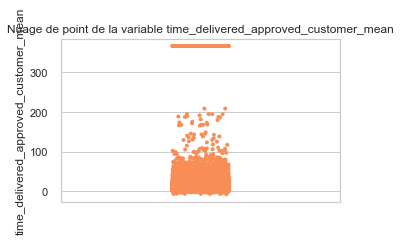

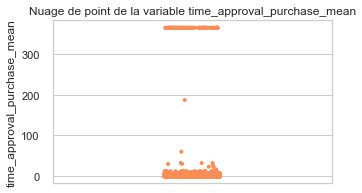

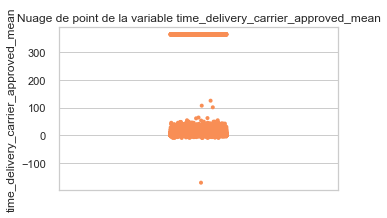

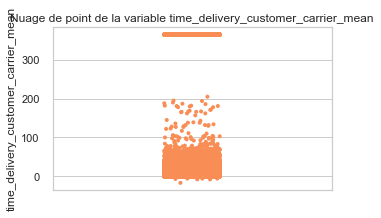

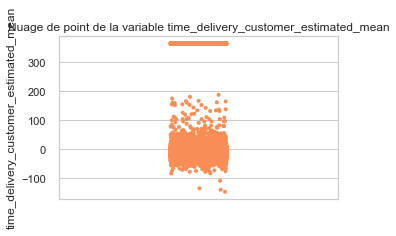

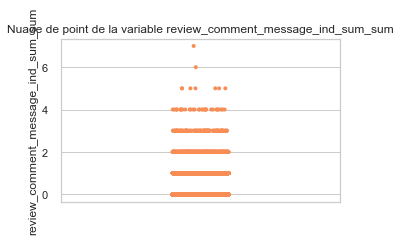

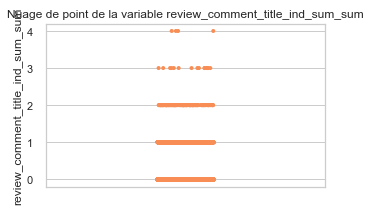

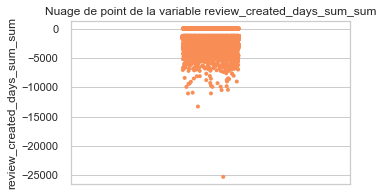

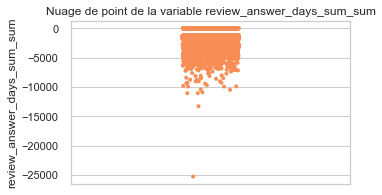

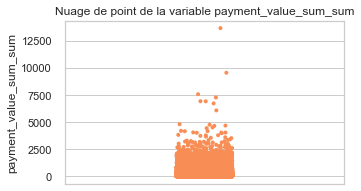

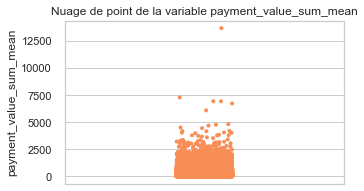

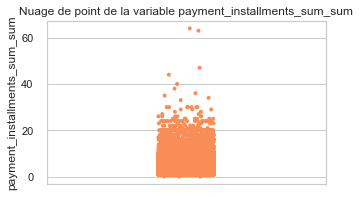

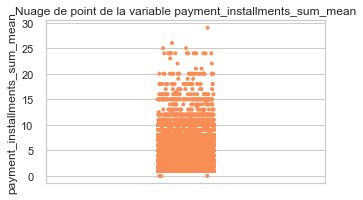

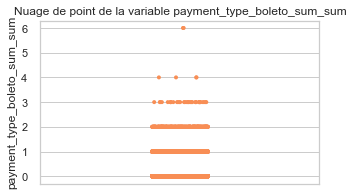

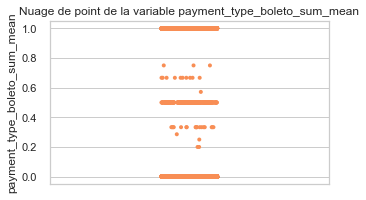

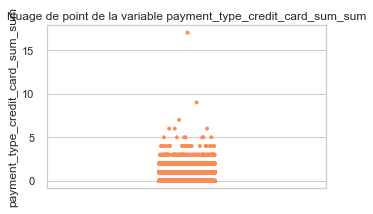

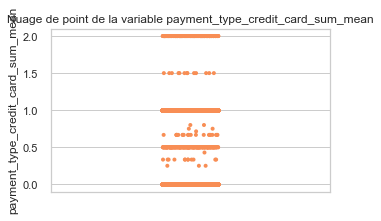

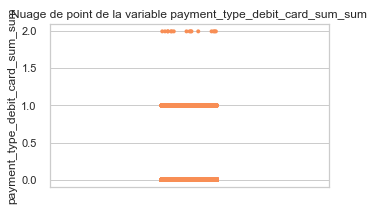

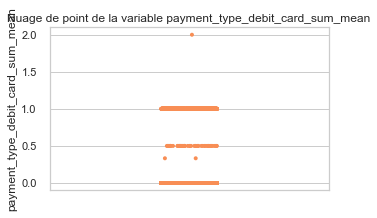

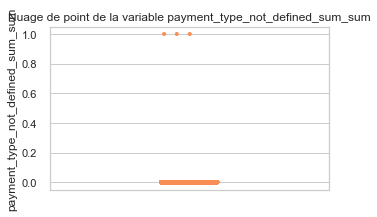

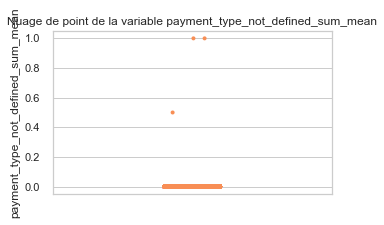

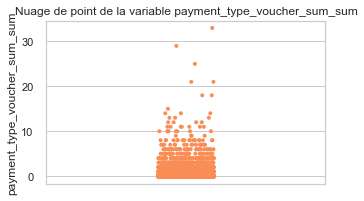

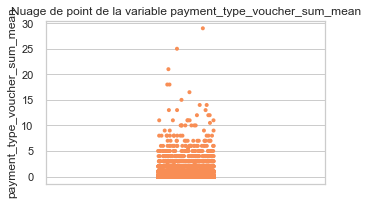

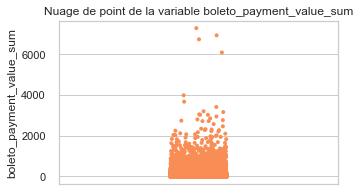

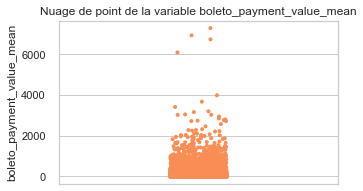

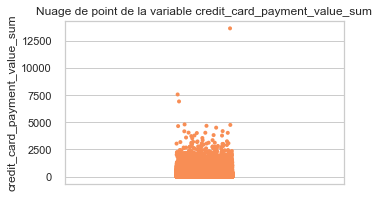

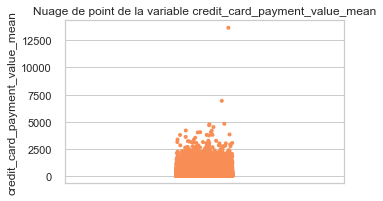

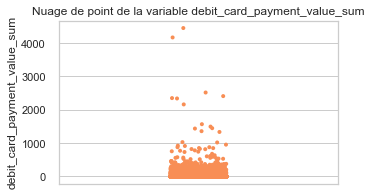

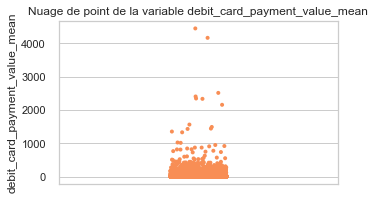

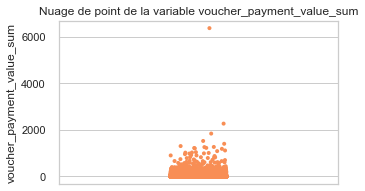

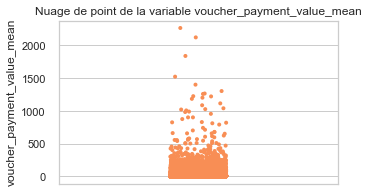

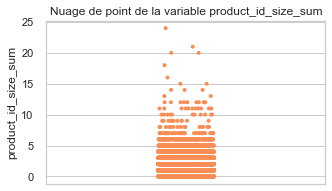

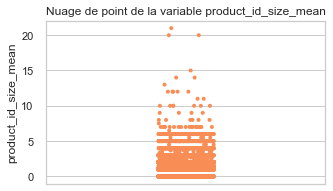

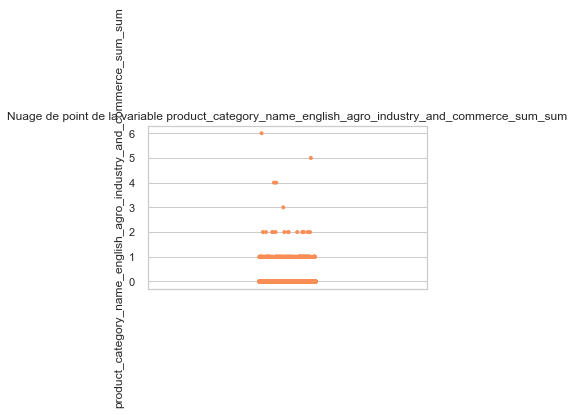

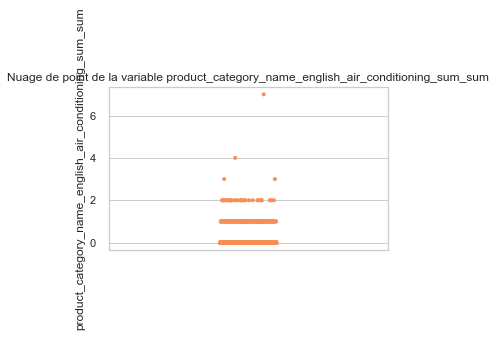

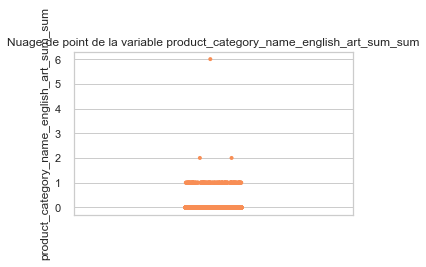

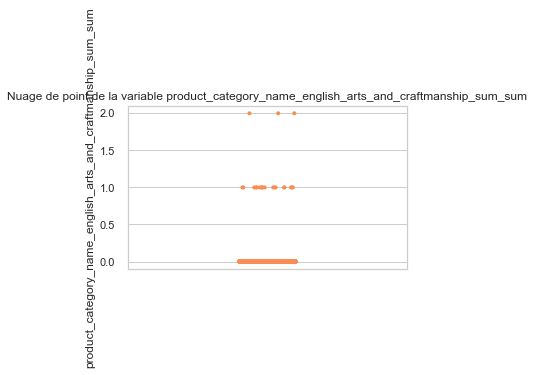

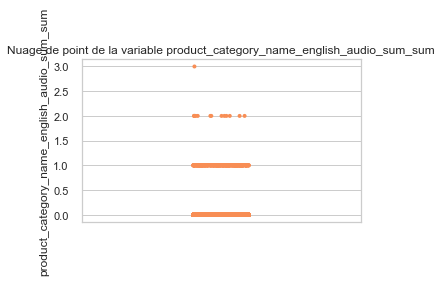

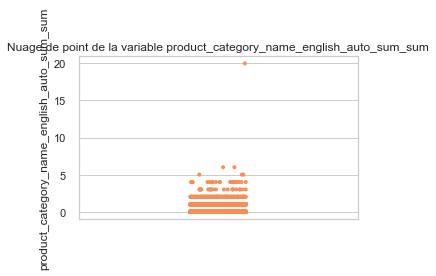

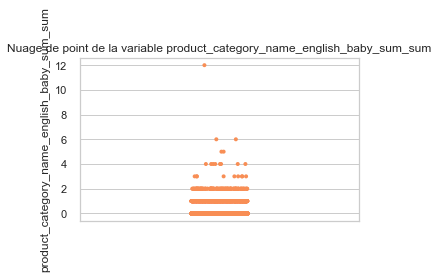

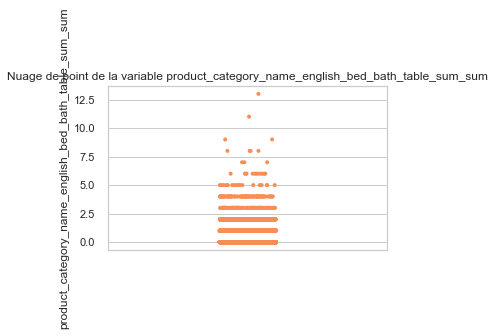

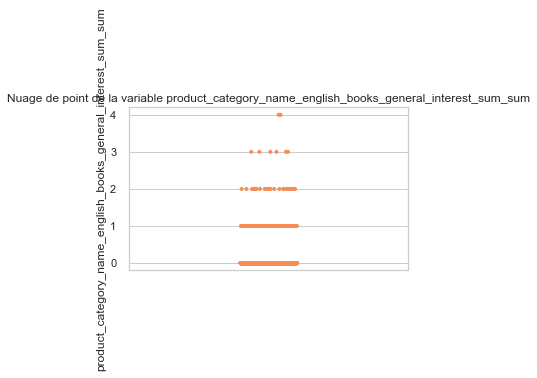

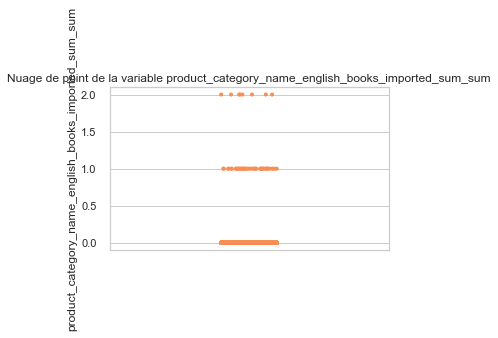

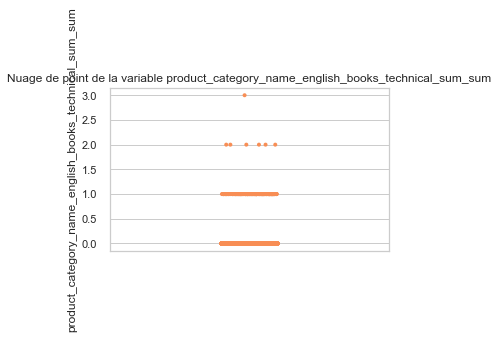

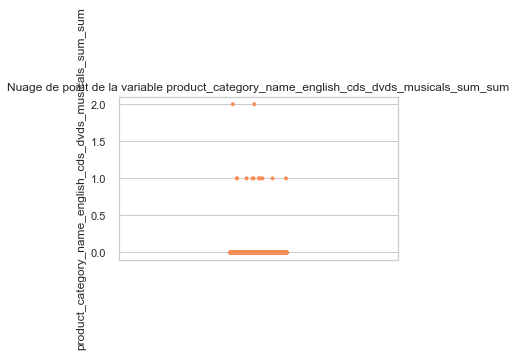

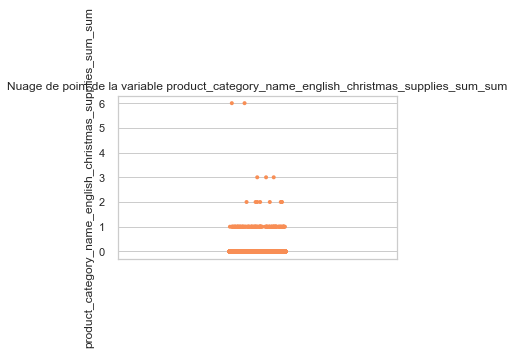

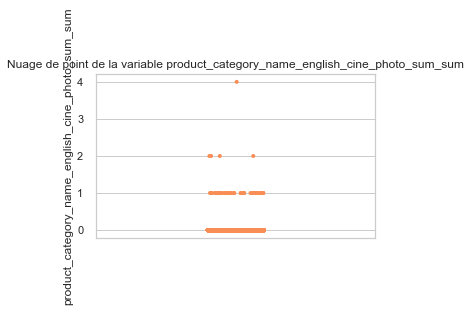

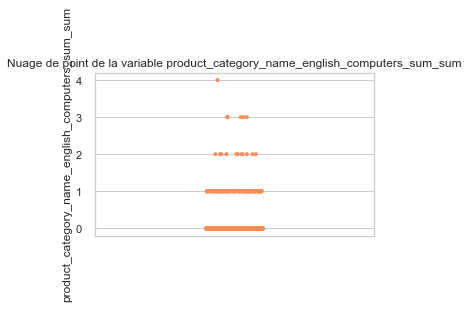

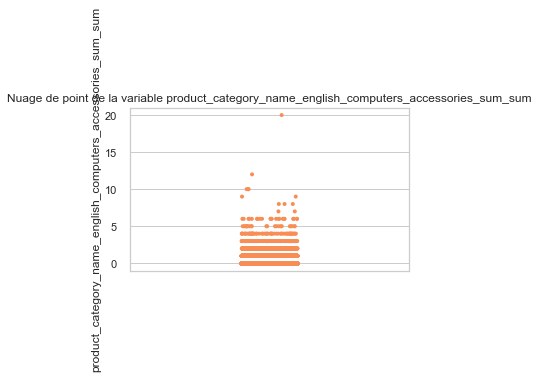

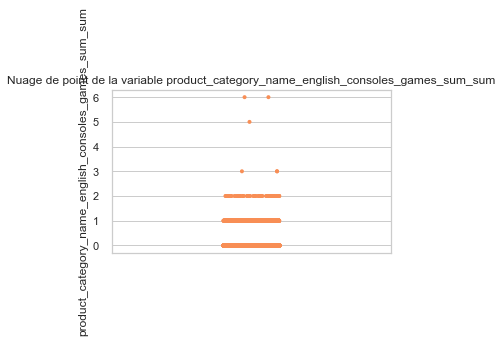

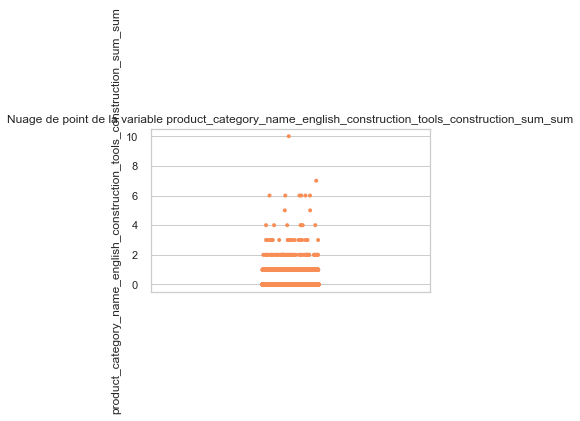

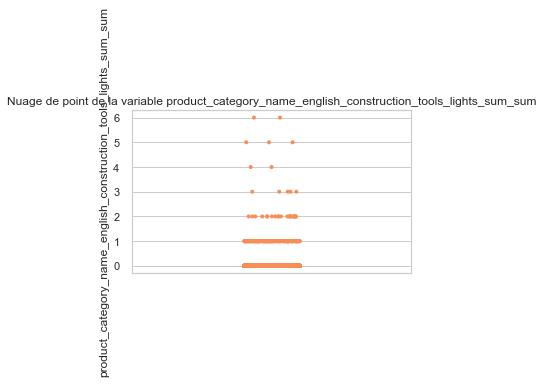

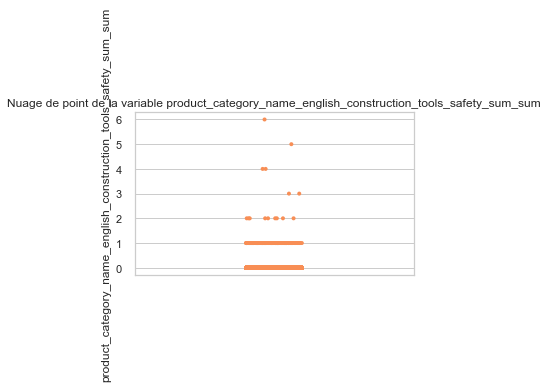

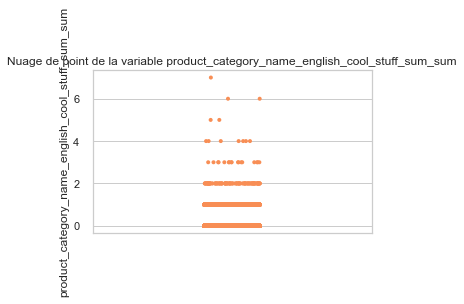

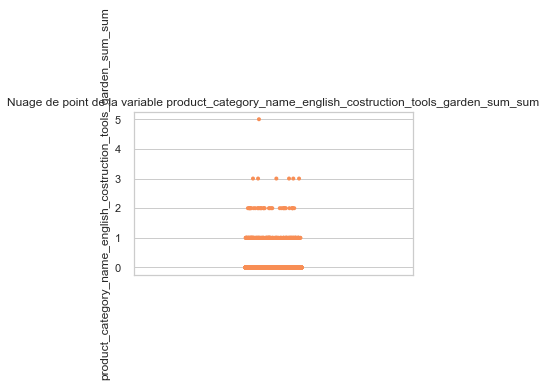

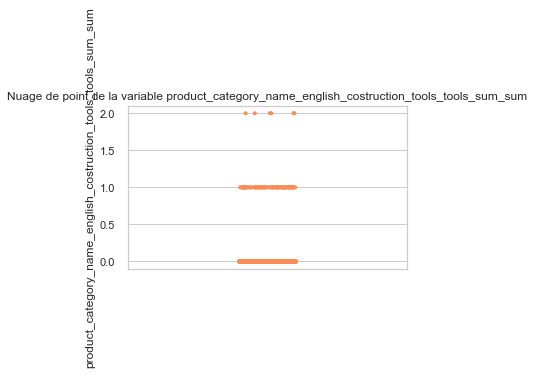

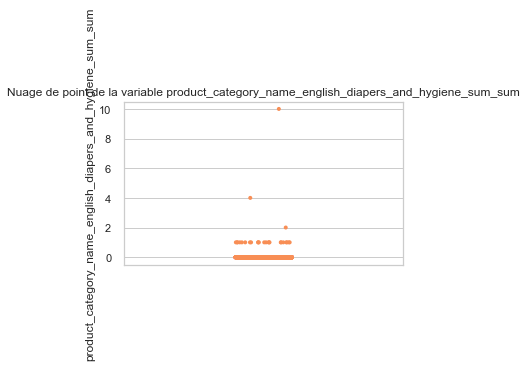

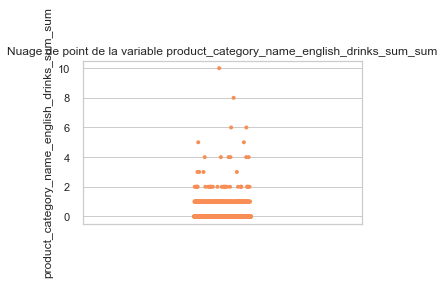

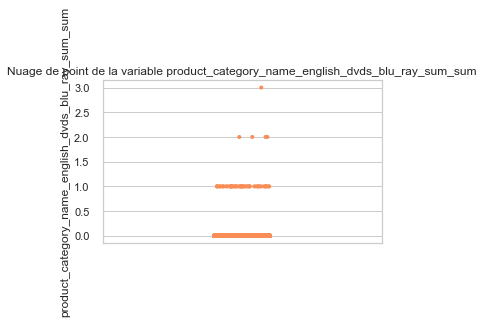

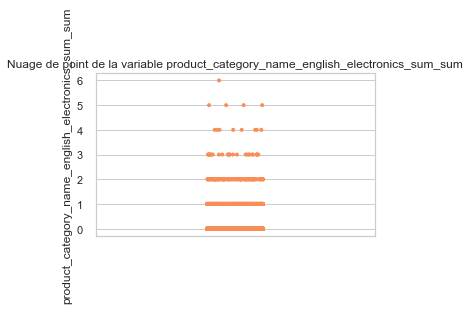

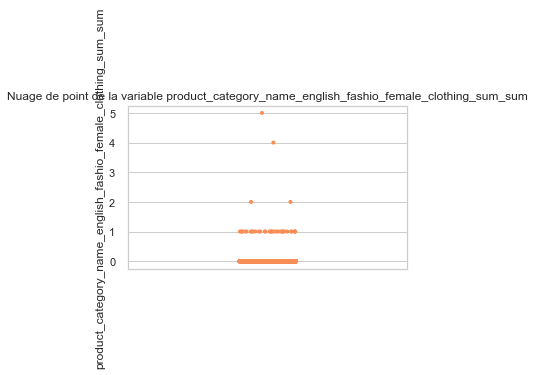

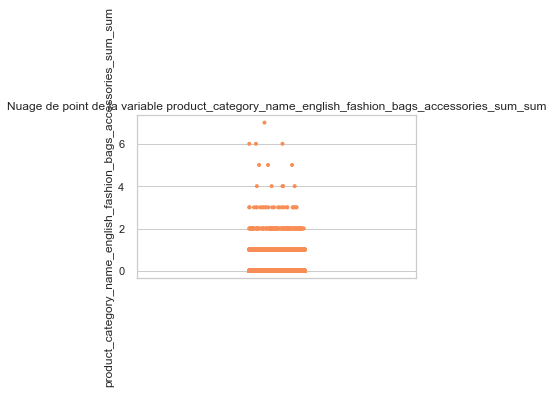

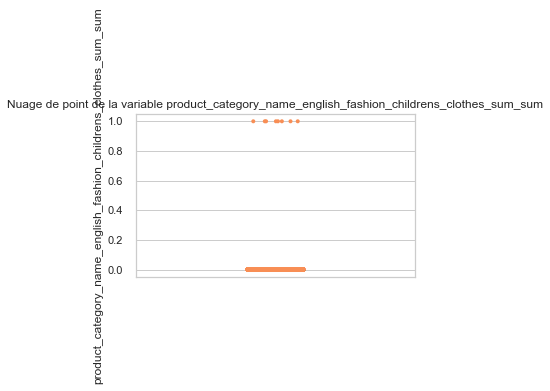

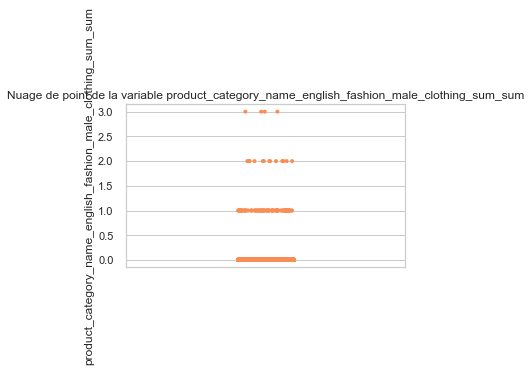

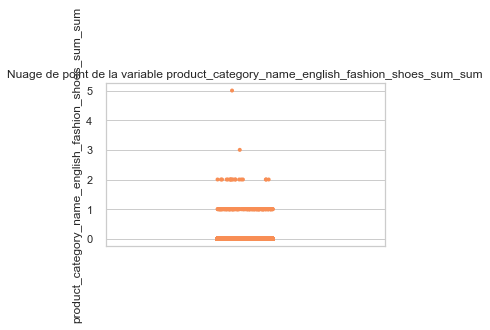

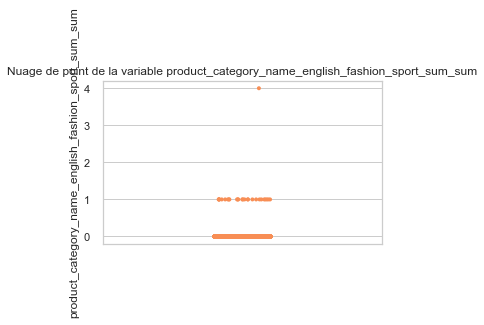

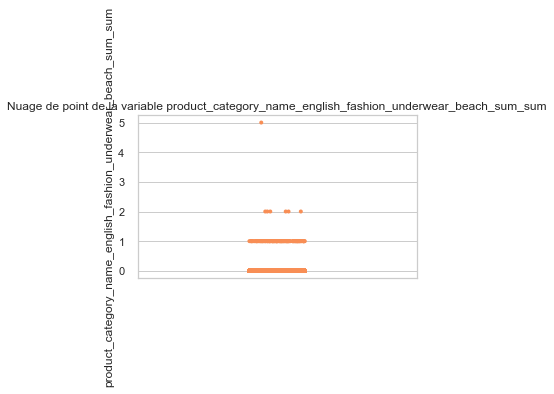

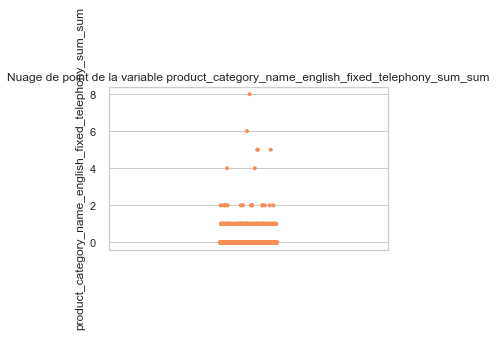

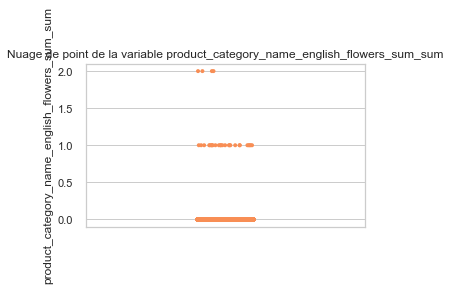

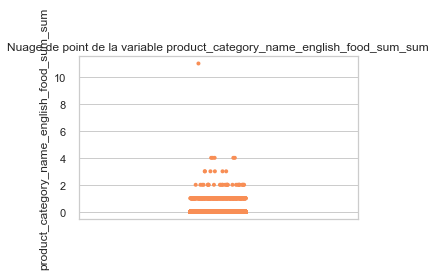

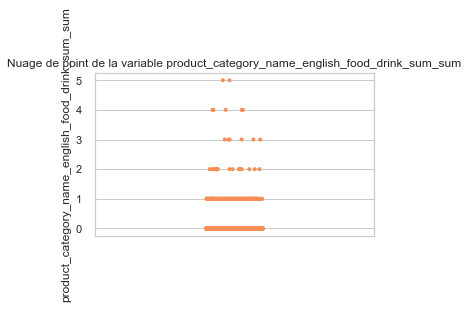

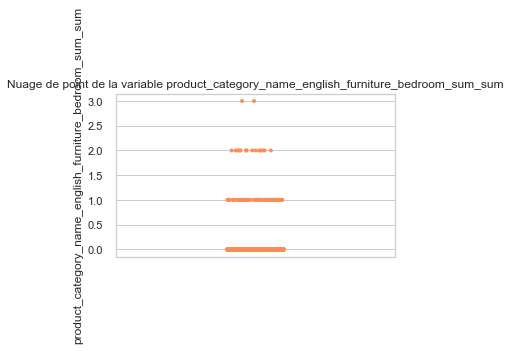

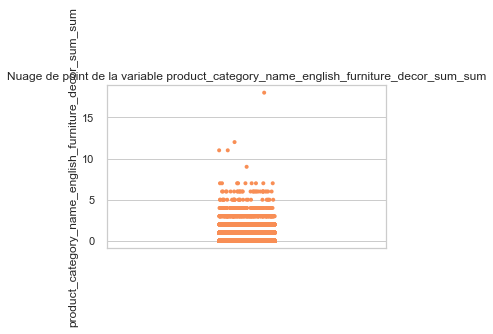

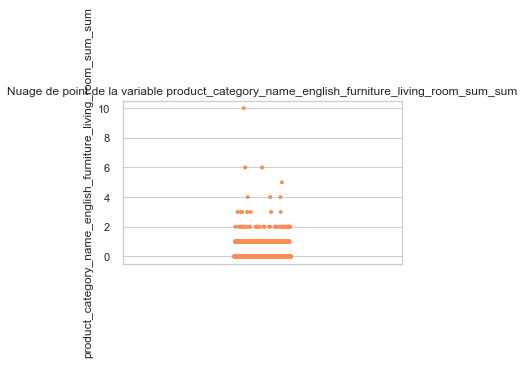

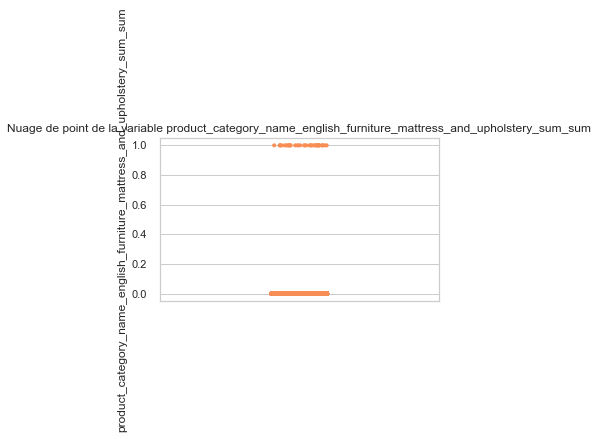

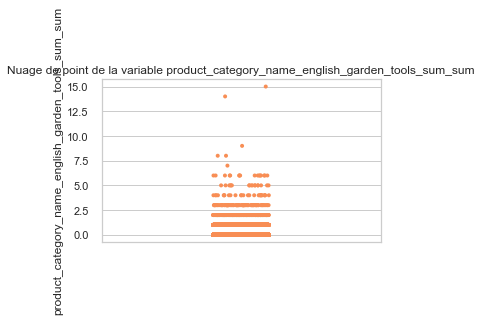

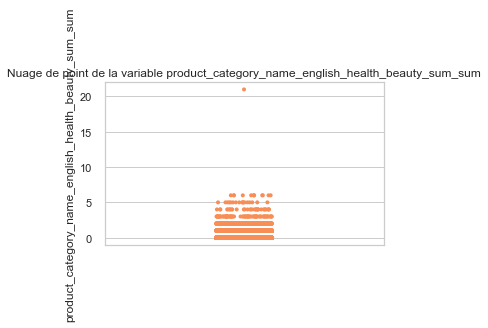

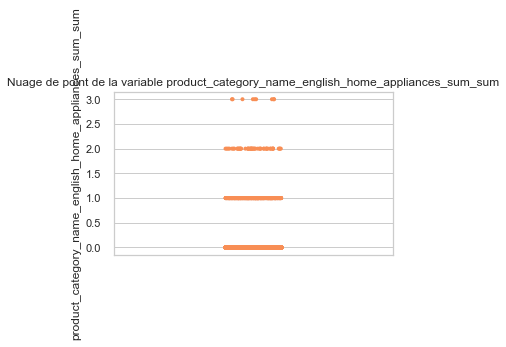

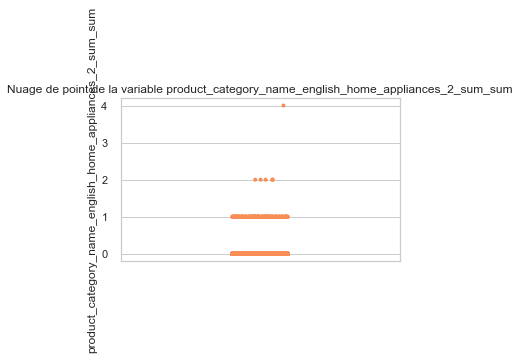

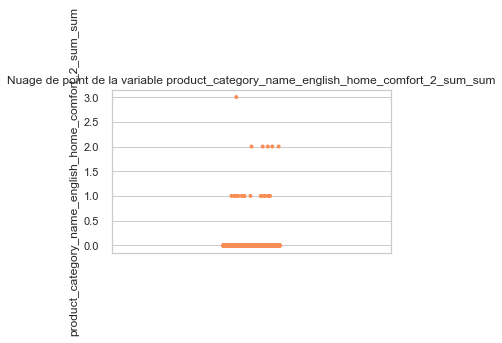

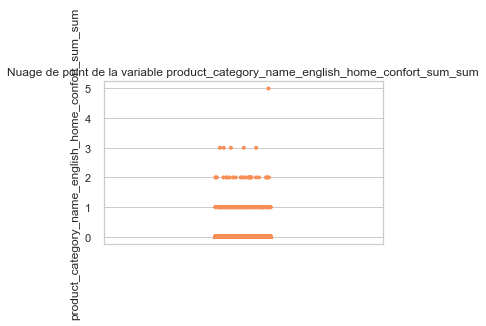

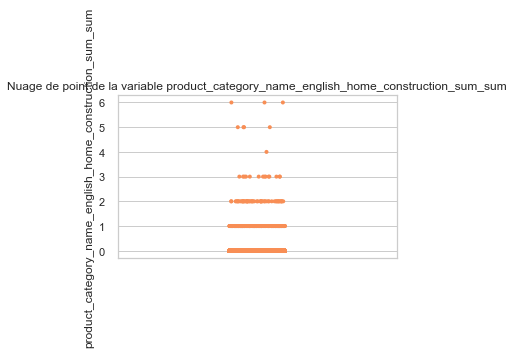

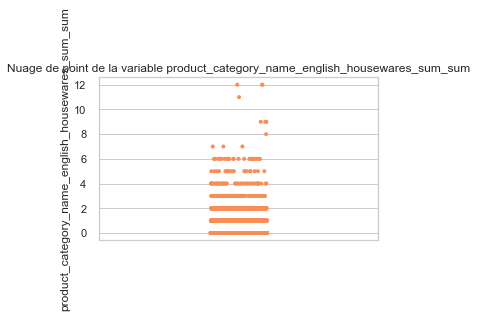

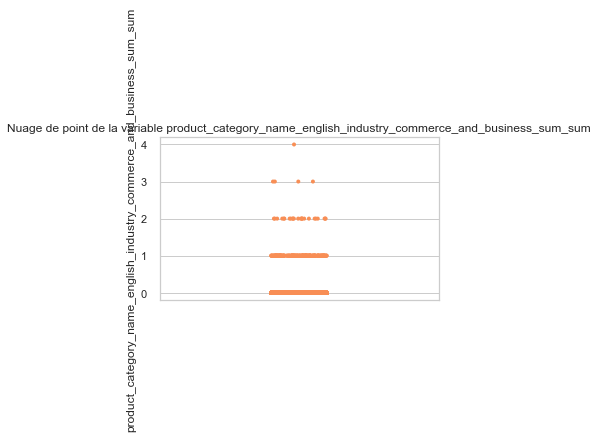

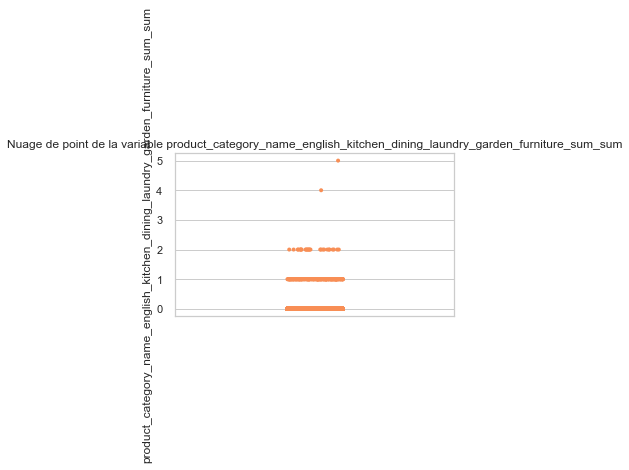

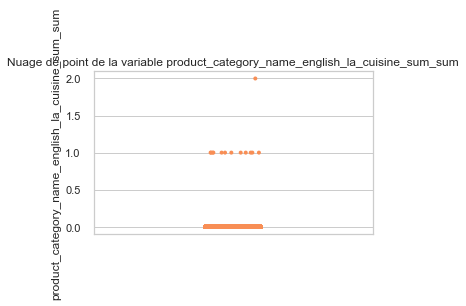

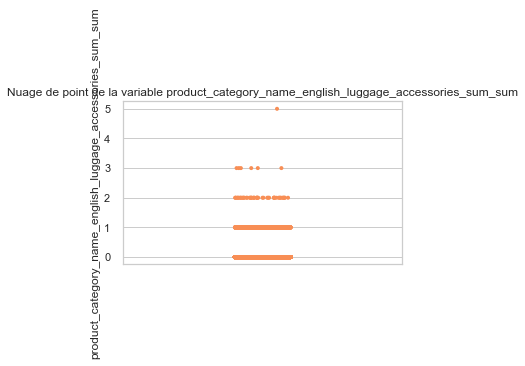

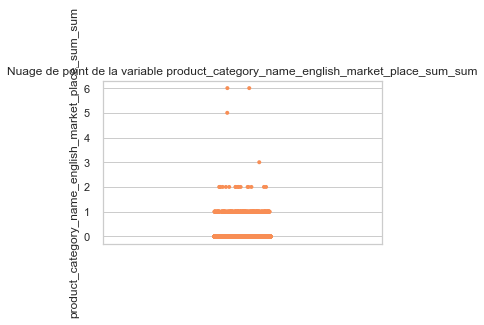

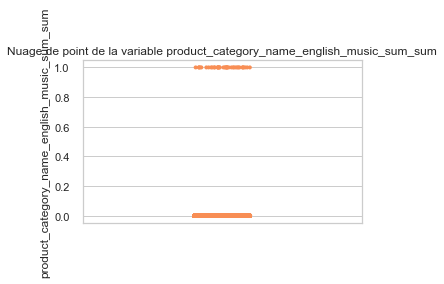

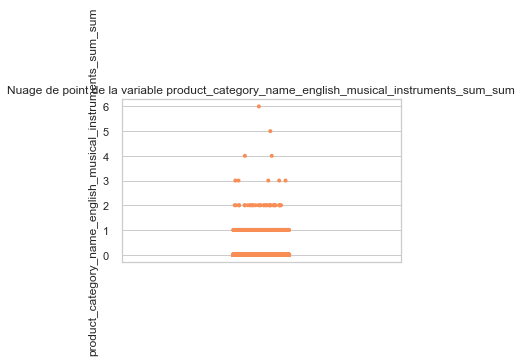

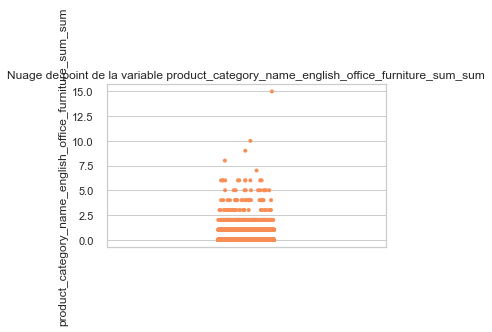

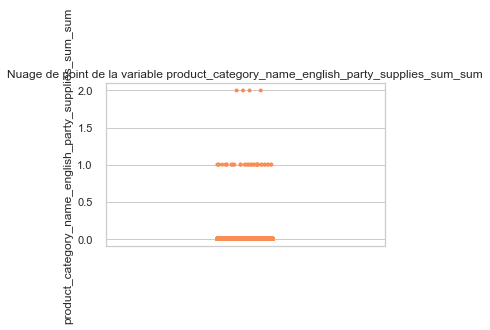

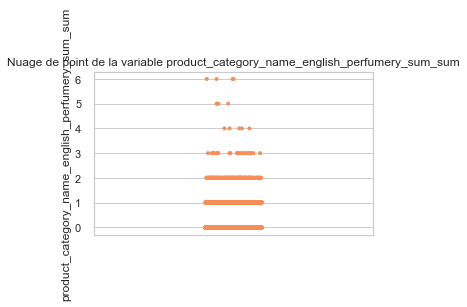

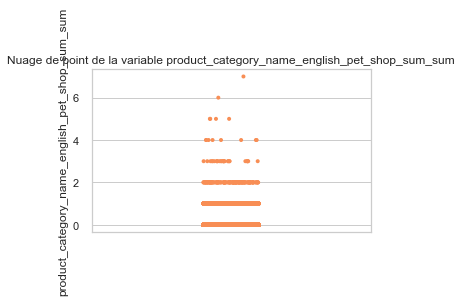

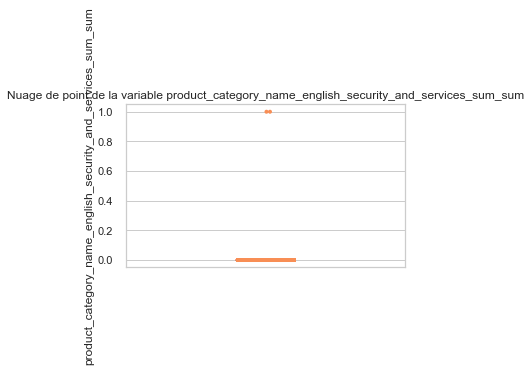

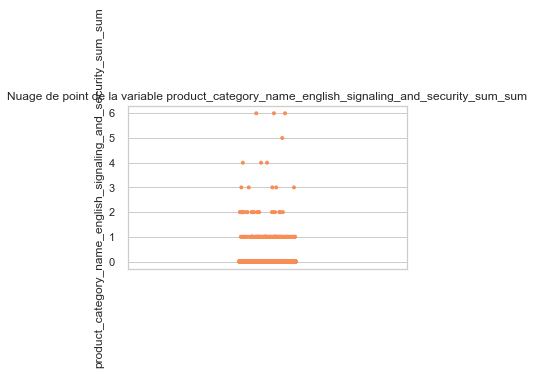

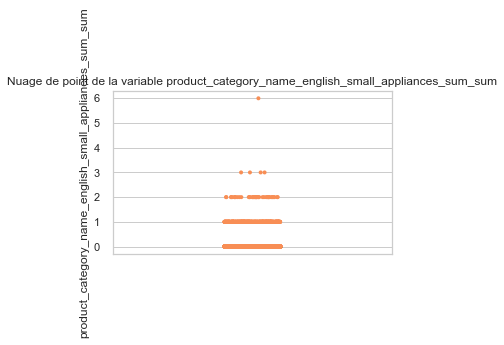

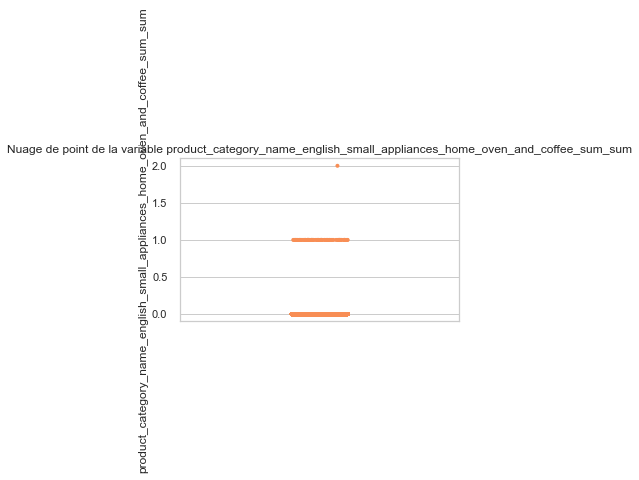

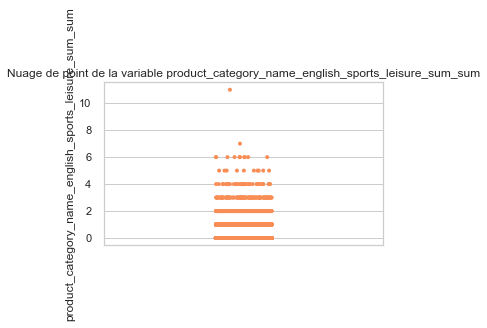

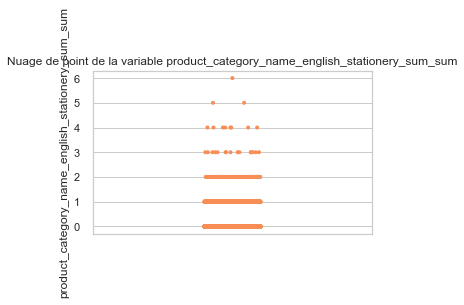

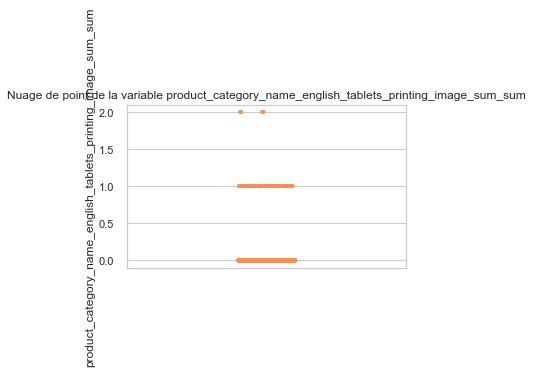

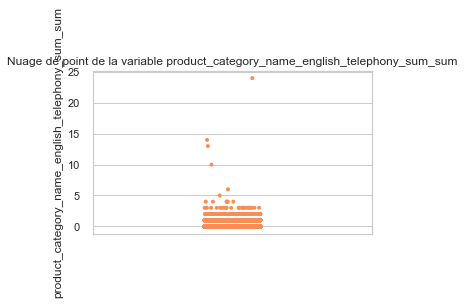

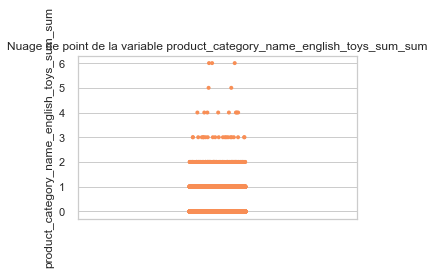

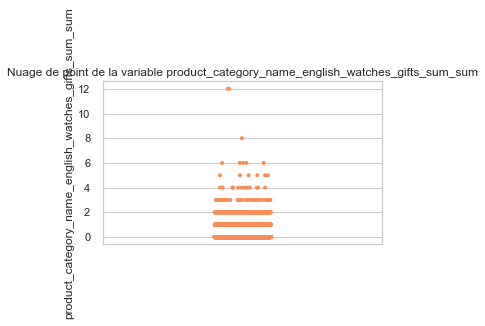

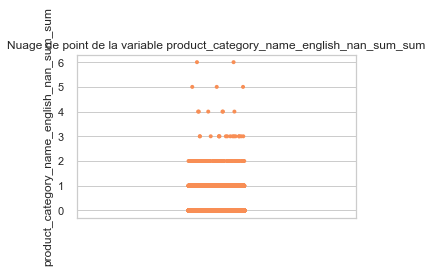

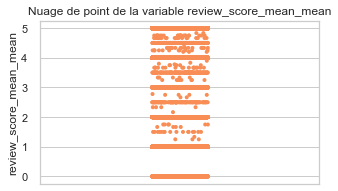

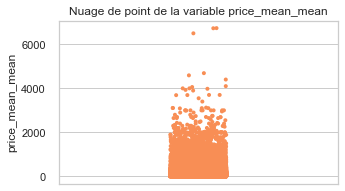

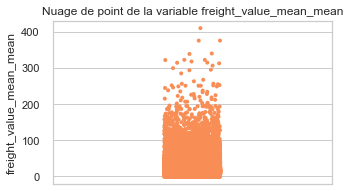

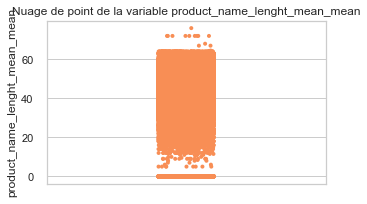

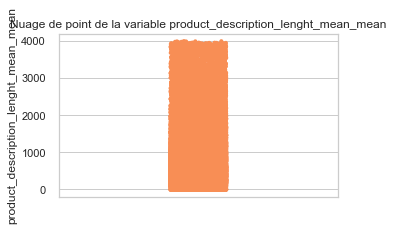

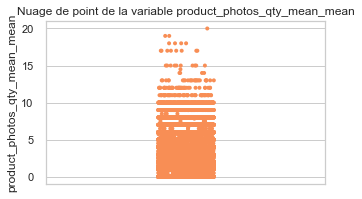

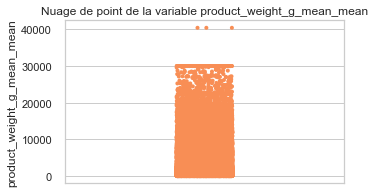

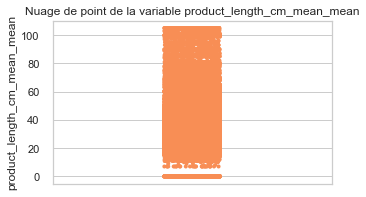

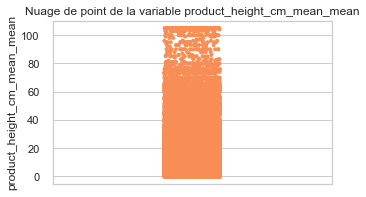

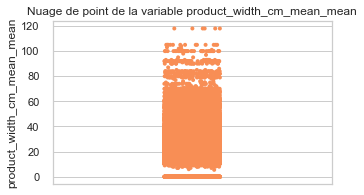

In [70]:
gc.collect()
for col in df.select_dtypes(include=['float64']).columns:
    pk.graph_stripplot(df,col, "Nuage de point de la variable "+col,(5,3),"#f88e55")

Il ne semble pas qu'il y ait des données aberrantes.

In [69]:
df.shape

(96096, 162)

Il reste 163 variables

In [ ]:
for col in df.select_dtypes(include=['float64']).columns:
        pk.graph_boxplot(df, col, "Boite à moustache de la variable "+col, "#f88e55", (14,8))

Les données sont peu dispersées au sein des variables, nous observons que toutes les boites à moustache sont aplaties.
Nous observons quand même des valeurs assez hautes. Il serait intéressant de créer des regoupements ordinaux

Realisons un test de skewness pour voir comment se comporte les distributions.

Nous rappelons :
- Si y1=0 alors la distribution est symétrique.
- Si y1>0 alors la distribution est étalée à droite.
- Si y1<0 alors la distribution est étalée à gauche.

In [ ]:
for col in df.select_dtypes(include=['float64']).columns:
    df_i=df[col].loc[pd.isna(df[col])==False]
    print("Variable : "+col+" ----- y1="+ str(df[col].skew()))

La plupart des distributions des variables sont étalées à droite.

Regardons comment nos variables se comportent par rapport à la loi normale grâce au test de kurtosis.

Nous rappelons les informations suivantes :
- Si γ2=0 , alors la distribution a le même aplatissement que la distribution normale.
- Si γ2>0 , alors elle est moins aplatie que la distribution normale : les observations sont plus concentrées.
- Si γ2<0 , alors les observations sont moins concentrées : la distribution est plus aplatie.

In [ ]:
for col in df.select_dtypes(include=['float64']).columns:
    df_i=df[col].loc[pd.isna(df[col])==False]
    print("Variable : "+col+" -- y2="+ str(df[col].kurtosis()))

La majorité des distributions des variables sont moins aplaties que la distribution de la loi normale.

In [ ]:
for col in df.columns:
    if df[col].nunique()<20 and df[col].nunique()>=6:
        pk.graph_barplot(df[col], "Répartition des clients selon la variable"+col, 
              (0.82, 0.28, 0.09),
              0, 40, col, "Fréquence en %",0,1, (11,7))
    if df[col].nunique()<6 and df[col].nunique()>2:
        pk.graph_circle(df[col], col, "Répartition des clients en fonction de la variable "+col)
    if df[col].nunique()<=2:
        pk.graph_pie(df[col], col, "Répartition des clients selon la variable "+col,["#f56315", "#f88e55"], (15,7)),
       

###############commentaires!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Il serait interessant de creer des regroupements ordinaux.

In [ ]:
reg_fisher_jenks(data, col, new_col, 5)

## Analyse bivariée

In [ ]:
gc.collect()

In [ ]:
for i in df.columns:
    print(i)

## correlation

In [ ]:
sns.set(rc={'figure.figsize':(10,4)})

data_corr = df.corr()

display(data_corr)
ax = sns.heatmap(data_corr, xticklabels = data_corr.columns , 
                 yticklabels = data_corr.columns, cmap = 'rocket_r')
plt.title("Matrice de corrélation")

plt.xlabel("Variables")

plt.ylabel("Variables")

## ACP

In [ ]:
df

In [ ]:
df_acp=df.copy()

In [ ]:
Z=pk.amulti_acp_standard(df_acp)

## Zoom segmentation RFM

### Recency

In [ ]:
df["order_purchase_timestamp_recency"].nunique()

In [ ]:
pk.graph_hist(df["order_purchase_timestamp_recency"],[0,50, 100, 200,300,400,500,600,772] ,"Distribution des clients en fonction de la variable order_purchase_timestamp_recency",
              "#f88e55", 0,772, 100, 0, 35000, "order_purchase_timestamp_recency", 'Fréquences',(11,7), 0, "")

### Frequency

# ########mettre en %

In [ ]:
df["order_id_size"].max()

In [ ]:
pk.graph_hist(df["order_id_size"],[0,1,2,3,4,5,6,7,8,9,10,15,17] ,"Distribution des clients en fonction de la variable order_id_size",
              "#f88e55", 0,17, 1, 0, 96000, "order_id_size", 'Fréquences',(11,7), 0, "")

### Revenue

In [ ]:
df["payment_value_sum_sum"].max()

In [ ]:
pk.graph_hist(df["payment_value_sum_sum"],[0,10,20,30,40,50,60,70,80,90, 100,500,1000,2000,13664.08] ,"Distribution des clients en fonction de la variable payment_value_sum_sum",
              "#f88e55", 0,13700, 10, 0, 55000, "payment_value_sum_sum", 'Fréquences',(11,7), 0, "")